source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [1]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

# scikit-learn
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # ImageFolder automatically assigns labels based on folder structure
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [3]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [75]:
# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms() 

# Create a dataset object
train_dataset = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_dataset = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)
val_dataset = SyntheticDataset(data_dir='dataset\\val', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# size of the training dataset
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 972
Validation dataset size: 203
Test dataset size: 111


In [66]:
# Get a dictionary associating target values with folder names
data_dir = 'dataset\\train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'bad', 1: 'good'}


In [99]:
# Training the model
num_epochs = 12

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
model.to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000008)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        
        # Validation phase
        model.eval()
        running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                # Move inputs and labels to the device
                images, labels = images.to(device), labels.to(device)
            
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
        print(f"Epoch {epoch+1}/{num_epochs} - Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}")

Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Epoch 1/12 - Train loss: 0.6872407430974544, Validation loss: 0.6775220421147464
Epoch 1/12 - Train accuracy: 0.5668724279835391, Validation accuracy: 0.5812807881773399


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 2/12 - Train loss: 0.5873156292938891, Validation loss: 0.6525604909863966
Epoch 2/12 - Train accuracy: 0.6965020576131687, Validation accuracy: 0.6305418719211823


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 3/12 - Train loss: 0.5165208357351797, Validation loss: 0.6332203067582229
Epoch 3/12 - Train accuracy: 0.7839506172839507, Validation accuracy: 0.6650246305418719


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Epoch 4/12 - Train loss: 0.4680214513231207, Validation loss: 0.6193011058081547
Epoch 4/12 - Train accuracy: 0.8199588477366255, Validation accuracy: 0.6551724137931034


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch 5/12 - Train loss: 0.4134618727022728, Validation loss: 0.6132452142943302
Epoch 5/12 - Train accuracy: 0.8755144032921811, Validation accuracy: 0.6650246305418719


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


Epoch 6/12 - Train loss: 0.3668410531532617, Validation loss: 0.6119785606861115
Epoch 6/12 - Train accuracy: 0.9084362139917695, Validation accuracy: 0.6847290640394089


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch 7/12 - Train loss: 0.3206396318757485, Validation loss: 0.6146385697602051
Epoch 7/12 - Train accuracy: 0.9362139917695473, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 8/12 - Train loss: 0.2866491625093138, Validation loss: 0.5996652088435412
Epoch 8/12 - Train accuracy: 0.9465020576131687, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


Epoch 9/12 - Train loss: 0.24621818340364307, Validation loss: 0.6050527694777315
Epoch 9/12 - Train accuracy: 0.9660493827160493, Validation accuracy: 0.7093596059113301


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Epoch 10/12 - Train loss: 0.2138228780693478, Validation loss: 0.6058922959078709
Epoch 10/12 - Train accuracy: 0.9804526748971193, Validation accuracy: 0.7192118226600985


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


Epoch 11/12 - Train loss: 0.18524216299439655, Validation loss: 0.6100308485512663
Epoch 11/12 - Train accuracy: 0.98559670781893, Validation accuracy: 0.7142857142857143


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

Epoch 12/12 - Train loss: 0.16669988944942568, Validation loss: 0.6136840830001925
Epoch 12/12 - Train accuracy: 0.9876543209876543, Validation accuracy: 0.7093596059113301


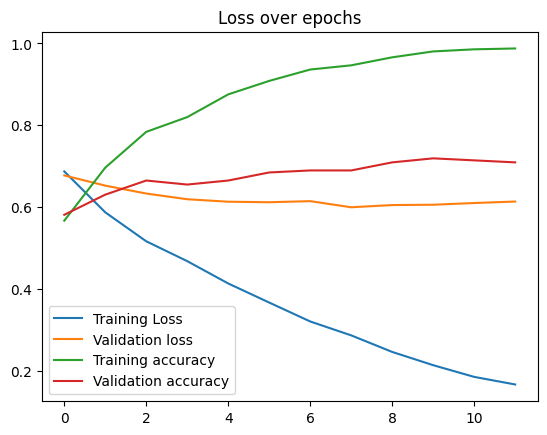

In [101]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Test dataset to determine the accuracy

In [102]:
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move images and labels to the device (assuming you're using GPU)
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
        # SKLEARN -> precision and accuracy classification report
        
        # Total correct predictions
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

Accuracy on the test set: 90.99%


# Inference

In [104]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [105]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

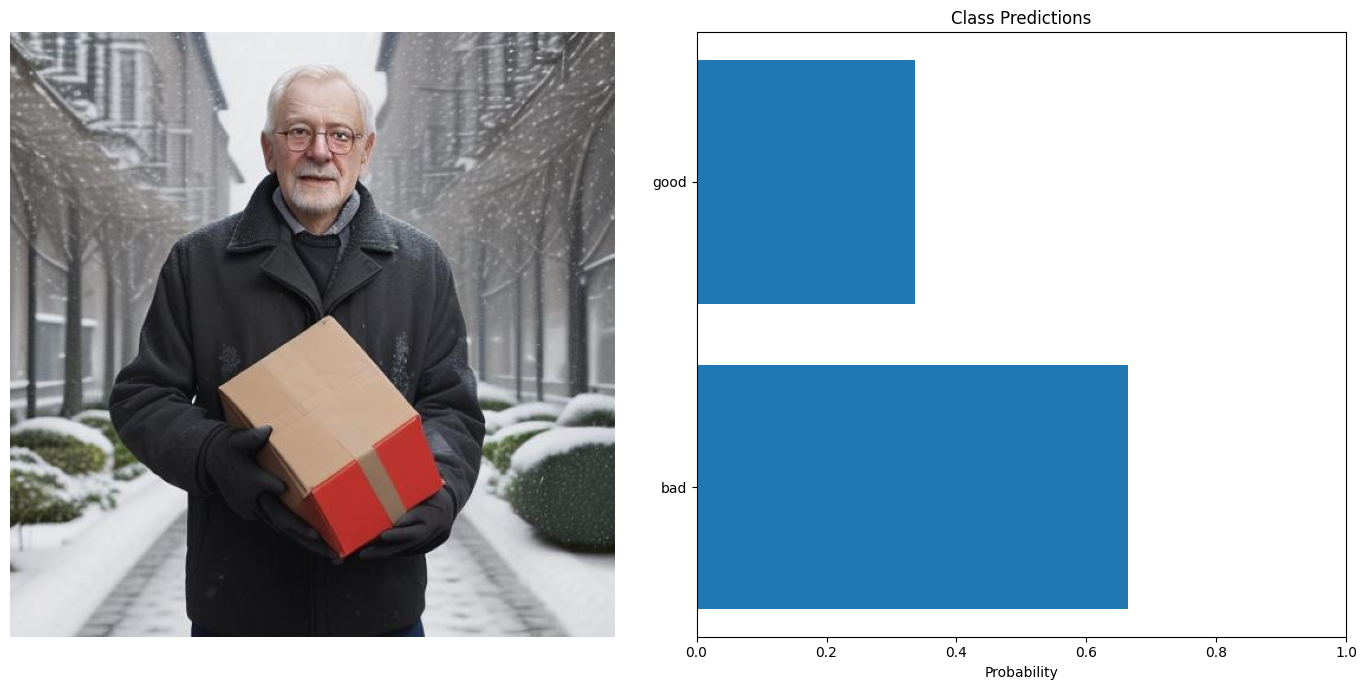

[0.6634703  0.33652964]


In [115]:
from PIL import Image
# Example usage
test_image = "data\\65_5.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)

In [108]:
# Run inference write to directory
import os

directory = 'data\\'
files = os.listdir(directory)
sorted_files = sorted(files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1].split('.')[0])))
print(sorted_files)

['1_1.jpg', '1_2.jpg', '1_3.jpg', '1_4.jpg', '1_5.jpg', '2_1.jpg', '2_2.jpg', '2_3.jpg', '2_4.jpg', '2_5.jpg', '3_1.jpg', '3_2.jpg', '3_3.jpg', '3_4.jpg', '3_5.jpg', '4_1.jpg', '4_2.jpg', '4_3.jpg', '4_4.jpg', '4_5.jpg', '5_1.jpg', '5_2.jpg', '5_3.jpg', '5_4.jpg', '5_5.jpg', '6_1.jpg', '6_2.jpg', '6_3.jpg', '6_4.jpg', '6_5.jpg', '7_1.jpg', '7_2.jpg', '7_3.jpg', '7_4.jpg', '7_5.jpg', '8_1.jpg', '8_2.jpg', '8_3.jpg', '8_4.jpg', '8_5.jpg', '9_1.jpg', '9_2.jpg', '9_3.jpg', '9_4.jpg', '9_5.jpg', '10_1.jpg', '10_2.jpg', '10_3.jpg', '10_4.jpg', '10_5.jpg', '11_1.jpg', '11_2.jpg', '11_3.jpg', '11_4.jpg', '11_5.jpg', '12_1.jpg', '12_2.jpg', '12_3.jpg', '12_4.jpg', '12_5.jpg', '13_1.jpg', '13_2.jpg', '13_3.jpg', '13_4.jpg', '13_5.jpg', '14_1.jpg', '14_2.jpg', '14_3.jpg', '14_4.jpg', '14_5.jpg', '15_1.jpg', '15_2.jpg', '15_3.jpg', '15_4.jpg', '15_5.jpg', '16_1.jpg', '16_2.jpg', '16_3.jpg', '16_4.jpg', '16_5.jpg', '17_1.jpg', '17_2.jpg', '17_3.jpg', '17_4.jpg', '17_5.jpg', '18_1.jpg', '18_2.jpg', 

In [116]:
for file in sorted_files:
    
    original_image, image_tensor = preprocess_image("data\\" + file, transform_operation) # determined earlier in the code
    probabilities = predict(model, image_tensor, device)
    print(probabilities)
    
    # 50% threshold for good
    if probabilities[1] > probabilities[0]:
        print(f"Image {file} is good, writing to good directory")
        original_image.save(f'results\\good\\{file}')
    else:
        print(f"Image {file} is bad, writing to bad directory")
        original_image.save(f'results\\bad\\{file}')

[0.7372988 0.2627012]
Image 1_1.jpg is bad, writing to bad directory
[0.15852499 0.841475  ]
Image 1_2.jpg is bad, writing to bad directory
[0.3471198 0.6528802]
Image 1_3.jpg is bad, writing to bad directory
[0.02139622 0.9786038 ]
Image 1_4.jpg is good, writing to good directory
[0.7744208  0.22557925]
Image 1_5.jpg is bad, writing to bad directory
[0.1299218  0.87007815]
Image 2_1.jpg is bad, writing to bad directory
[0.63736904 0.36263093]
Image 2_2.jpg is bad, writing to bad directory
[0.85484    0.14516003]
Image 2_3.jpg is bad, writing to bad directory
[0.37888563 0.6211144 ]
Image 2_4.jpg is bad, writing to bad directory
[0.2711684 0.7288316]
Image 2_5.jpg is bad, writing to bad directory
[0.0310686  0.96893144]
Image 3_1.jpg is good, writing to good directory
[0.31373528 0.68626475]
Image 3_2.jpg is bad, writing to bad directory
[0.57302445 0.42697558]
Image 3_3.jpg is bad, writing to bad directory
[0.68940747 0.3105925 ]
Image 3_4.jpg is bad, writing to bad directory
[0.21549